<a href="https://colab.research.google.com/github/ruthelphor/Projet-TM_Detection/blob/master/Projet_court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet court : Classification d’images bruitées de chiffres**


## **1. Charger les images avec numpy.load()**


First, import some modules necessary for data analysis and transformation:

In [13]:
import pandas as pd
import numpy as np
#import sklearn
import matplotlib.pyplot as plt
import os
import requests
from tqdm.auto import tqdm

Read the data to variables (it will take some time for x since we have a lot of data):

In [12]:
train_images = np.load("/train_images.npy")
train_labels = np.load("/train_labels.npy")
test_images = np.load("/test_images.npy")
test_labels = np.load("/test_labels.npy")

## **2. Visualiser quelques images:**

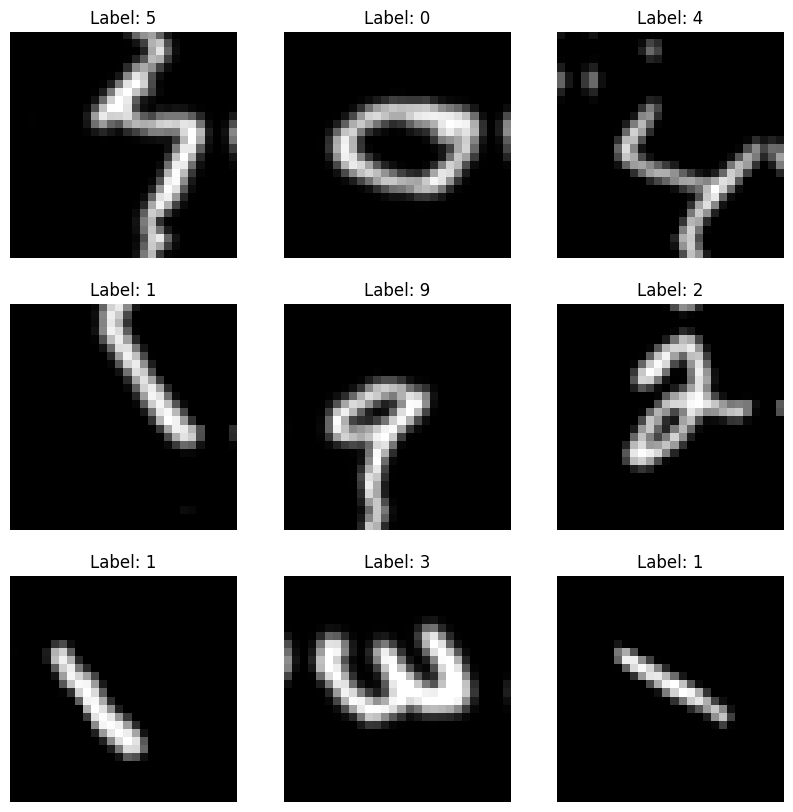

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

How many examples do we have in our dataset?

In [29]:
print(f'X:\n {train_images}\nY:\n{train_labels}')
print(f'Shape of data X_train:{train_images.shape}\n')
print(f'Shape of data Y_train:{train_labels.shape}\n')
print(f'Shape of data X_test:{test_images.shape}\n')
print(f'Shape of data Y_test:{test_labels.shape}\n')

X:
 [[[[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  ...

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]

  [[0.05773444]
   [0.05773444]
   [0.05773444]
   ...
   [0.05773444]
   [0.05773444]
   [0.05773444]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   

## **3. Premier apprentissage et validation de la classification**

**Modèle de base avec deux couches entièrement connectées :**

* Fonction d'activation des neurones : Rectified Linear Unit (ReLU).

* Fonction d'activation de sortie : Softmax (pour la classification multi-classes).

* Fonction de coût : Cross-entropy (entropie croisée).

* Deux couches cachées avec respectivement 256 et 128 neurones.

* Dropout : 30 % (technique pour éviter le surapprentissage).

* Optimiseur : RMSprop.

### Préparation

Importation des modules nécessaires pour la construction de modèles d'apprentissage profond.

In [17]:
!pip install scikeras

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

from keras.layers import Conv1D, Flatten
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier
# Utily function from keras
#from keras.utils import np_utils
# Plot model
#from keras.utils import plot_model
# Optimizers
from tensorflow.keras import optimizers

# Useful Sklearn library
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics

from keras.utils import to_categorical
from keras.utils import plot_model

One hot encoding of class Y

In [32]:
y_train_oh = to_categorical(train_labels)
y_test_oh = to_categorical(test_labels)
print(f'One hot encoding of y_train : {y_train_oh}\n')
print(f'Shape of y_train_oh : {y_train_oh.shape}')

print(f'One hot encoding of y_test : {y_oh}\n')
print(f'Shape of y_test_oh : {y_test_oh.shape}')

One hot encoding of y_train : [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Shape of y_train_oh : (60000, 10)
One hot encoding of y_test : [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Shape of y_test_oh : (10000, 10)


Afficher la forme des données avant la division:

In [36]:
print(f'X_train shape : {train_images.shape}')
print(f'Y_train one-hot shape : {y_train_oh.shape}')
print(f'X_test shape : {test_images.shape}')
print(f'Y_test one-hot shape : {y_test_oh.shape}')

X_train shape : (60000, 28, 28, 1)
Y_train one-hot shape : (60000, 10)
X_test shape : (10000, 28, 28, 1)
Y_test one-hot shape : (10000, 10)


Division des données d'entraînement pour avoir un ensemble de validation

In [37]:
X_train_final, X_val, y_train_final, y_val = train_test_split(train_images, y_train_oh, test_size=0.2, random_state=3, shuffle=True)


Afficher les formes des ensembles après la division:

In [38]:
print(f'X_train_final shape : {X_train_final.shape}')
print(f'X_val shape : {X_val.shape}')
print(f'y_train_final shape : {y_train_final.shape}')
print(f'y_val shape : {y_val.shape}')

X_train_final shape : (48000, 28, 28, 1)
X_val shape : (12000, 28, 28, 1)
y_train_final shape : (48000, 10)
y_val shape : (12000, 10)


Définition du modèle

In [24]:
def dense_model_mnist():
    # Créer le modèle séquentiel
    model = Sequential()

    # Première couche dense avec 256 neurones et ReLU
    model.add(Dense(256, input_shape=(28*28,), activation='relu'))

    # Dropout de 30% pour régularisation
    model.add(Dropout(0.3))

    # Deuxième couche dense avec 128 neurones et ReLU
    model.add(Dense(128, activation='relu'))

    # Dropout de 30% pour régularisation
    model.add(Dropout(0.3))

    # Couche de sortie avec 10 neurones (10 classes pour les chiffres 0 à 9) avec softmax
    model.add(Dense(10, activation='softmax'))

    # Utilisation de l'optimiseur RMSprop
    opt = RMSprop()

    # Compilation du modèle avec categorical crossentropy et métrique de précision
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model


Résumé et structure du modele

In [63]:
model = dense_model_mnist()
print(f'{model.summary()}')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


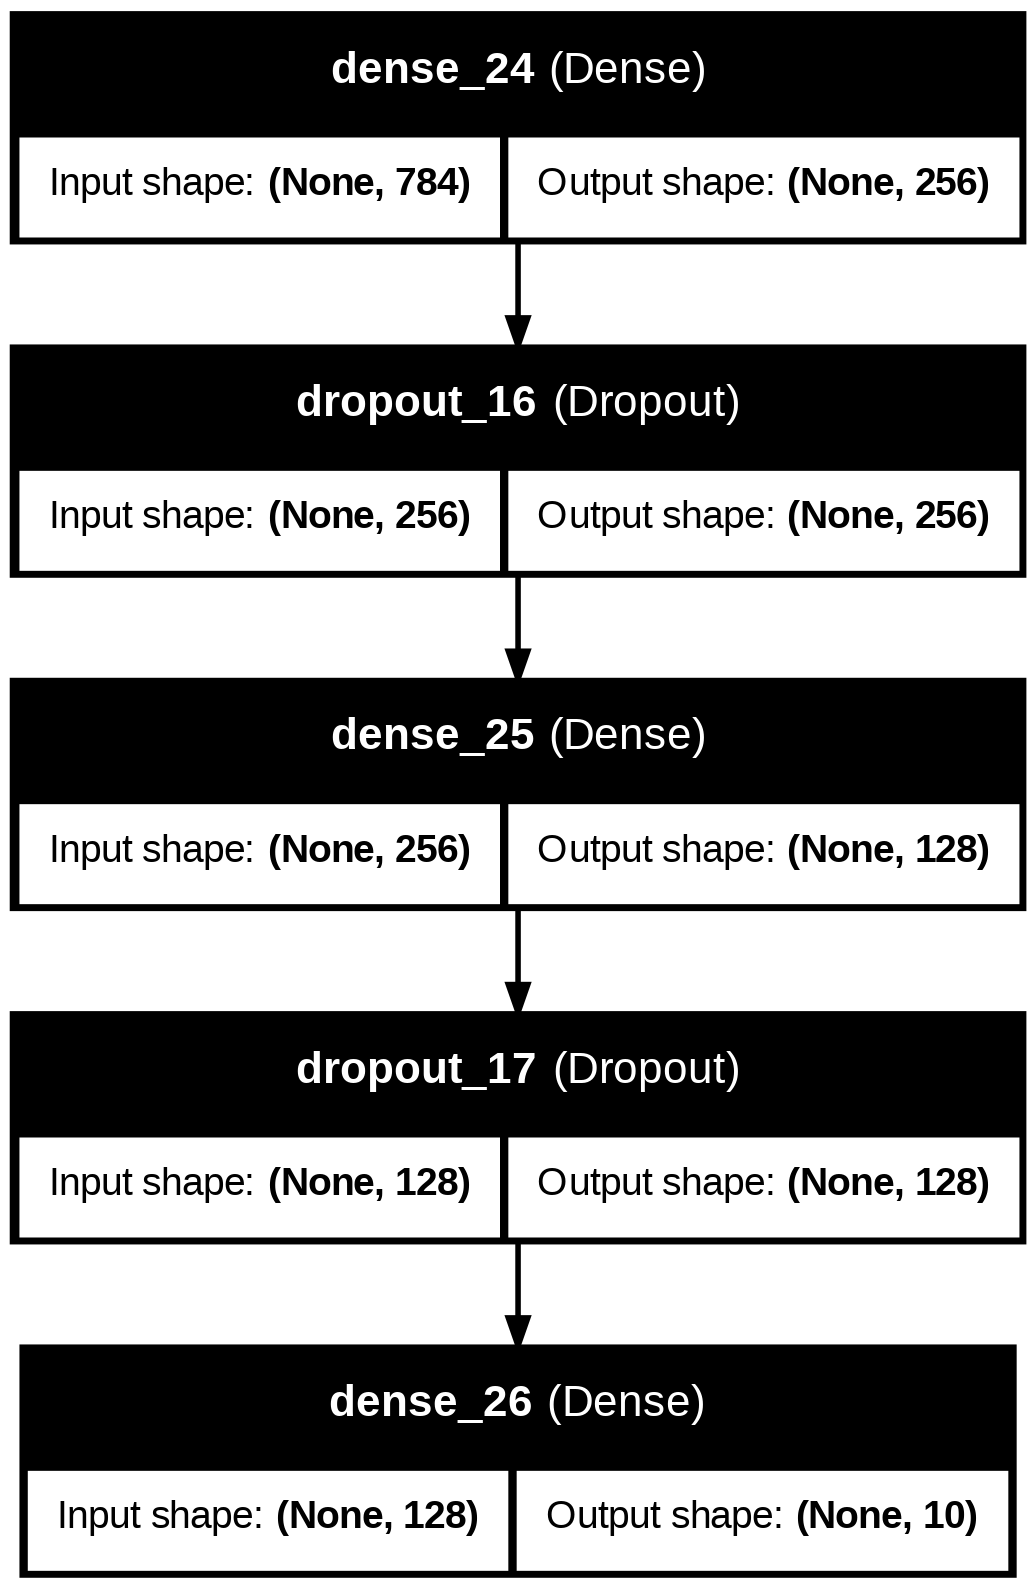

In [64]:
plot_model(model, to_file="model.png",show_shapes=True, show_layer_names=True)

Prétraitement des données (mise à plat des images 28x28 en vecteurs 784)

In [78]:
X_train_1D = train_images.reshape(-1, 28*28)
X_test_1D = test_images.reshape(-1, 28*28)

print(f'X_train_1D shape: {X_train_1D.shape}')
print(f'y_train_oh shape: {y_train_oh.shape}')
print(f'X_test_1D shape: {X_test_1D.shape}')
print(f'y_test_oh shape: {y_test_oh.shape}')

X_train_1D shape: (60000, 784)
y_train_oh shape: (60000, 10)
X_test_1D shape: (10000, 784)
y_test_oh shape: (10000, 10)


In [65]:
history = model.fit(X_train_1D, y_train_oh, epochs=20, batch_size=50, validation_split=0.2)

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2786 - loss: 2.0137 - val_accuracy: 0.6042 - val_loss: 1.2604
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5401 - loss: 1.3552 - val_accuracy: 0.6791 - val_loss: 1.0093
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6112 - loss: 1.1718 - val_accuracy: 0.7218 - val_loss: 0.9095
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6487 - loss: 1.0703 - val_accuracy: 0.7422 - val_loss: 0.8280
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6733 - loss: 1.0091 - val_accuracy: 0.7684 - val_loss: 0.7495
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6863 - loss: 0.9733 - val_accuracy: 0.7703 - val_loss: 0.7492
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6999 - loss: 0.9227 - val_accuracy: 0.7874 - val_loss: 0.6950
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7102 - loss: 0.9035 - val_accuracy: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


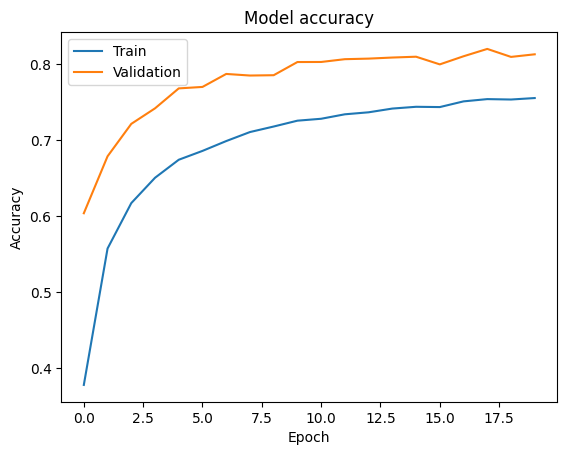

In [66]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
model.evaluate(X_test_1D, y_test_oh)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7384 - loss: 216.3635


[198.87818908691406, 0.7534999847412109]

In [82]:
y_pred = model.predict(X_test_1D)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

y_test_classes = np.argmax(y_test_oh,axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [83]:
y_test_classes

array([7, 2, 1, ..., 4, 5, 6])

<Axes: >

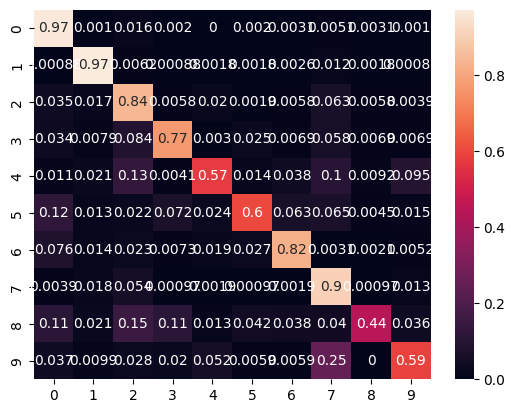

In [84]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes, normalize="true"), annot=True)

<Axes: >

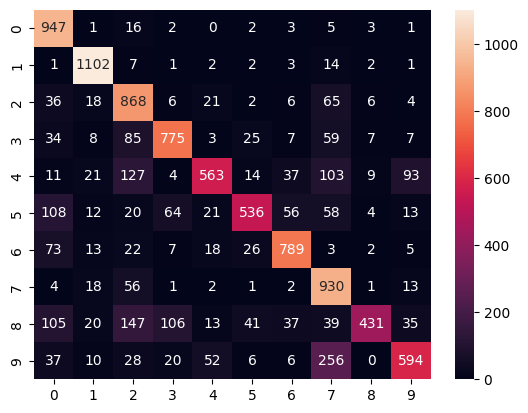

In [85]:
import seaborn as sns
sns.heatmap(sklearn.metrics.confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')

## **4. Deuxième apprentissage avec des couches de convolution 2D**